<a href="https://colab.research.google.com/github/lovelyoyrmia/Foedtra/blob/main/Machine%20Learning/foedtra_modelv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Foedtra Model 3

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import os

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
  
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, MaxPooling2D
from keras.preprocessing import image

## Load dataset

In [ ]:
root_path = '/content/drive/MyDrive/Capstone Project - Foedtra'
labels = os.path.join(root_path, 'dataframe', 'train_images.xlsx')
sample = os.path.join(root_path, 'dataframe', 'test_images.xlsx')

train_path = os.path.join(root_path, 'dataset', 'train')
test_path = os.path.join(root_path, 'dataset','test')

In [ ]:
def rename_path_images(name, labels, dirs):
  return os.path.join(os.path.join('/content/drive/MyDrive/Capstone Project - Foedtra/dataset', dirs, labels), name)

In [ ]:
train_df = pd.read_excel(labels)
test_df = pd.read_excel(sample)
dev_df = pd.read_excel(os.path.join(root_path, 'dataframe','dev_images.xlsx'))

In [ ]:
train_df['Filepath'] = train_df.apply(lambda x: rename_path_images(x['Filepath'], x['Label'], 'train'), axis=1)
test_df['Filepath'] = test_df.apply(lambda x: rename_path_images(x['Filepath'], x['Label'], 'test'), axis=1)

In [ ]:
print('Train has {} classes'.format(len(list(train_df['Label'].unique()))))
print('Test has {} classes'.format(len(list(test_df['Label'].unique()))))

Train has 34 classes
Test has 34 classes


## Image augmentation

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=False,
    shear_range=0.3,
    zoom_range=0.3,
    validation_split=0.2,
)

test_gen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_images = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
)

Found 920 validated image filenames belonging to 34 classes.
Found 230 validated image filenames belonging to 34 classes.
Found 331 validated image filenames belonging to 34 classes.


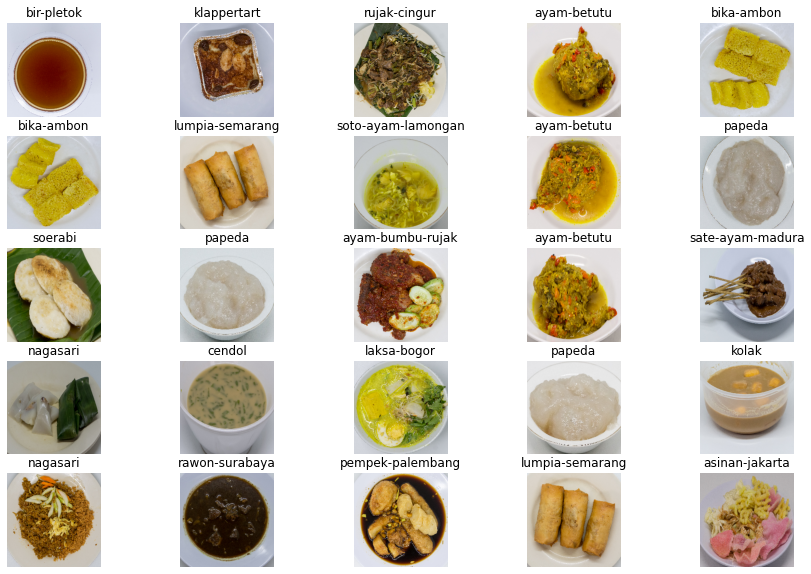

In [ ]:
a = train_images.class_indices
class_names = list(a.keys())
  
def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.imshow(img[i])
      plt.title(class_names[np.argmax(labels[i])])
      plt.axis('off')
    plt.show()

x, y = next(test_images)
plot_images(x,y)

## Modeling

In [ ]:
model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(34, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.999:
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
callbacks = myCallback()
STEP_SIZE_TRAIN = train_images.n//train_images.batch_size
STEP_SIZE_VALID = val_images.n//val_images.batch_size
history = model.fit(
    train_images, 
    validation_data=val_images, 
    steps_per_epoch=STEP_SIZE_TRAIN, 
    validation_steps=STEP_SIZE_VALID,
    epochs=20,
    callbacks=[callbacks]
)

Epoch 1/20
28/28 [==============================] - 472s 17s/step - loss: 3.4810 - acc: 0.0709 - val_loss: 3.3009 - val_acc: 0.0848
Epoch 2/20
28/28 [==============================] - 98s 4s/step - loss: 2.7604 - acc: 0.1948 - val_loss: 2.4932 - val_acc: 0.3170
Epoch 3/20
28/28 [==============================] - 98s 4s/step - loss: 2.0019 - acc: 0.3840 - val_loss: 1.6691 - val_acc: 0.4821
Epoch 4/20
28/28 [==============================] - 98s 4s/step - loss: 1.3776 - acc: 0.5687 - val_loss: 0.9821 - val_acc: 0.6652
Epoch 5/20
28/28 [==============================] - 98s 3s/step - loss: 1.1095 - acc: 0.6599 - val_loss: 0.7701 - val_acc: 0.7500
Epoch 6/20
28/28 [==============================] - 110s 4s/step - loss: 0.7451 - acc: 0.7500 - val_loss: 0.5938 - val_acc: 0.7768
Epoch 7/20
28/28 [==============================] - 98s 3s/step - loss: 0.5326 - acc: 0.8119 - val_loss: 0.4812 - val_acc: 0.8527
Epoch 8/20
28/28 [==============================] - 97s 3s/step - loss: 0.6446 - acc: 0

In [ ]:
model.save('foedtra-model3.h5')

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9459459185600281\nValidation Accuracy: 0.9598214030265808')

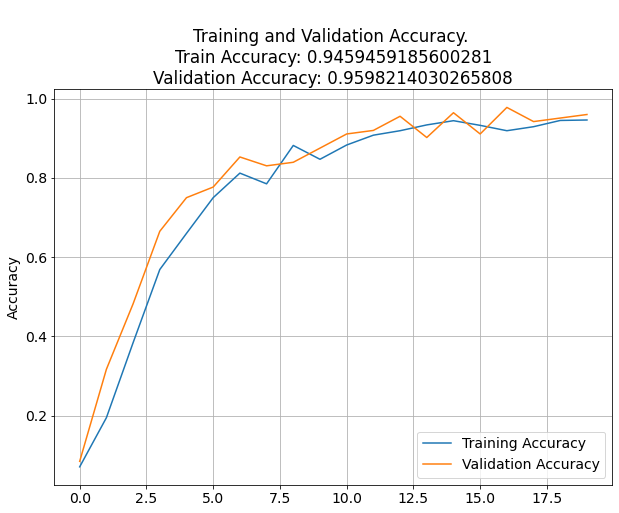

In [ ]:
# store results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
  
  
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

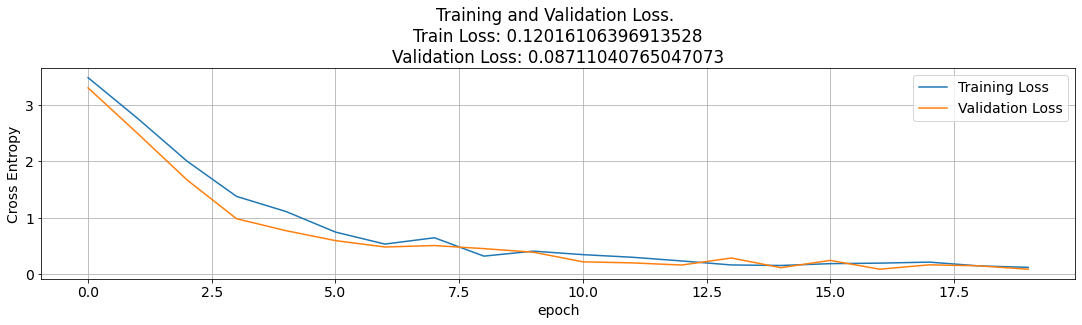

In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
accuracy_score = model.evaluate(val_images)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 

print("Loss: ",accuracy_score[0])

8/8 [==============================] - 20s 2s/step - loss: 0.0905 - acc: 0.9652
[0.09047874808311462, 0.9652174115180969]
Accuracy: 96.5217%
Loss:  0.09047874808311462


In [ ]:
results = model.evaluate(test_images, verbose=0)
print('Test Accuracy: {:.2f}%'.format(results[1] * 100))

Test Accuracy: 94.56%


In [ ]:
def predict_model_from_dir(class_names):
  predictions = []
    
  for image in test_df['Filepath']:
      img = tf.keras.preprocessing.image.load_img(image)
      img = tf.keras.preprocessing.image.img_to_array(img)
      img = tf.keras.preprocessing.image.smart_resize(img, (224, 224))
      img = tf.reshape(img, (-1, 224, 224, 3))
      prediction = model.predict(img/255)
      prediction = np.argmax(prediction)
      prediction = class_names[prediction]
      predictions.append(prediction)

  return predictions

class_names = list(test_images.class_indices.keys())
predictions = predict_model_from_dir(class_names)
my_submission = pd.DataFrame({'image_id': test_df['Filepath'], 'label':  predictions})
my_submission.to_excel('submission.xlsx', index=False, header=True)

In [ ]:
predicted_model = pd.read_excel('submission.xlsx')

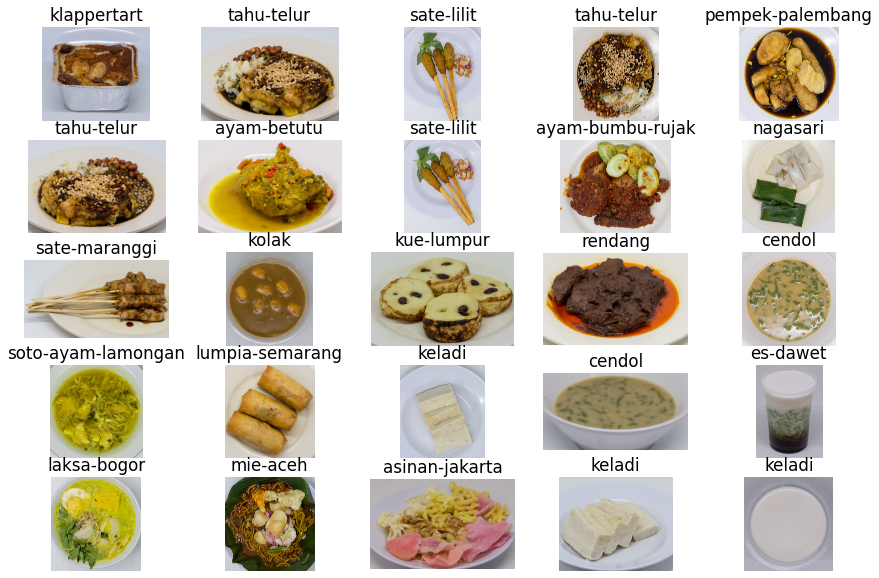

In [ ]:
plt.figure(figsize=[15,10])
for i in range(25):
  plt.subplot(5,5,i+1)
  image_test = plt.imread(predicted_model['image_id'][i])
  plt.imshow(image_test)
  plt.title(predicted_model['label'][i])
  plt.axis('off')
plt.show()

In [ ]:
def predict_image(path_image):
  img = tf.keras.preprocessing.image.load_img(path_image)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.preprocessing.image.smart_resize(img, (224, 224))
  img = tf.reshape(img, (-1, 224, 224, 3))
  prediction = model.predict(img/255)
  prediction = np.argmax(prediction)
  prediction = class_names[prediction]
  plt.title(prediction)
  img = plt.imread(path_image)
  plt.imshow(img)
  plt.show()

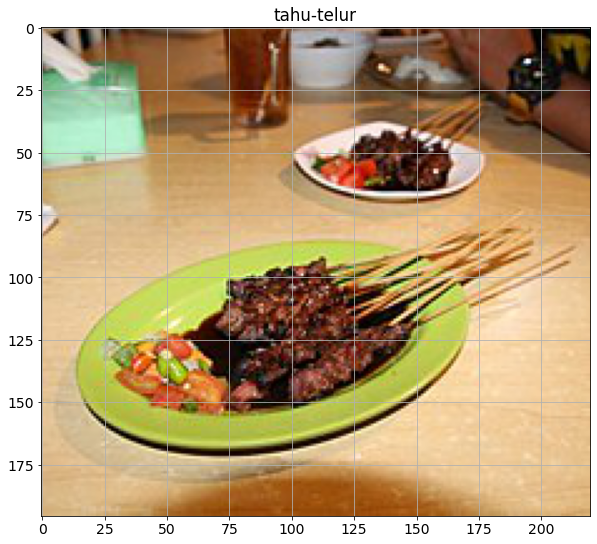

In [ ]:
predict_image('/content/220px-Sate_Maranggi_1.jpg')

In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)
cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions)

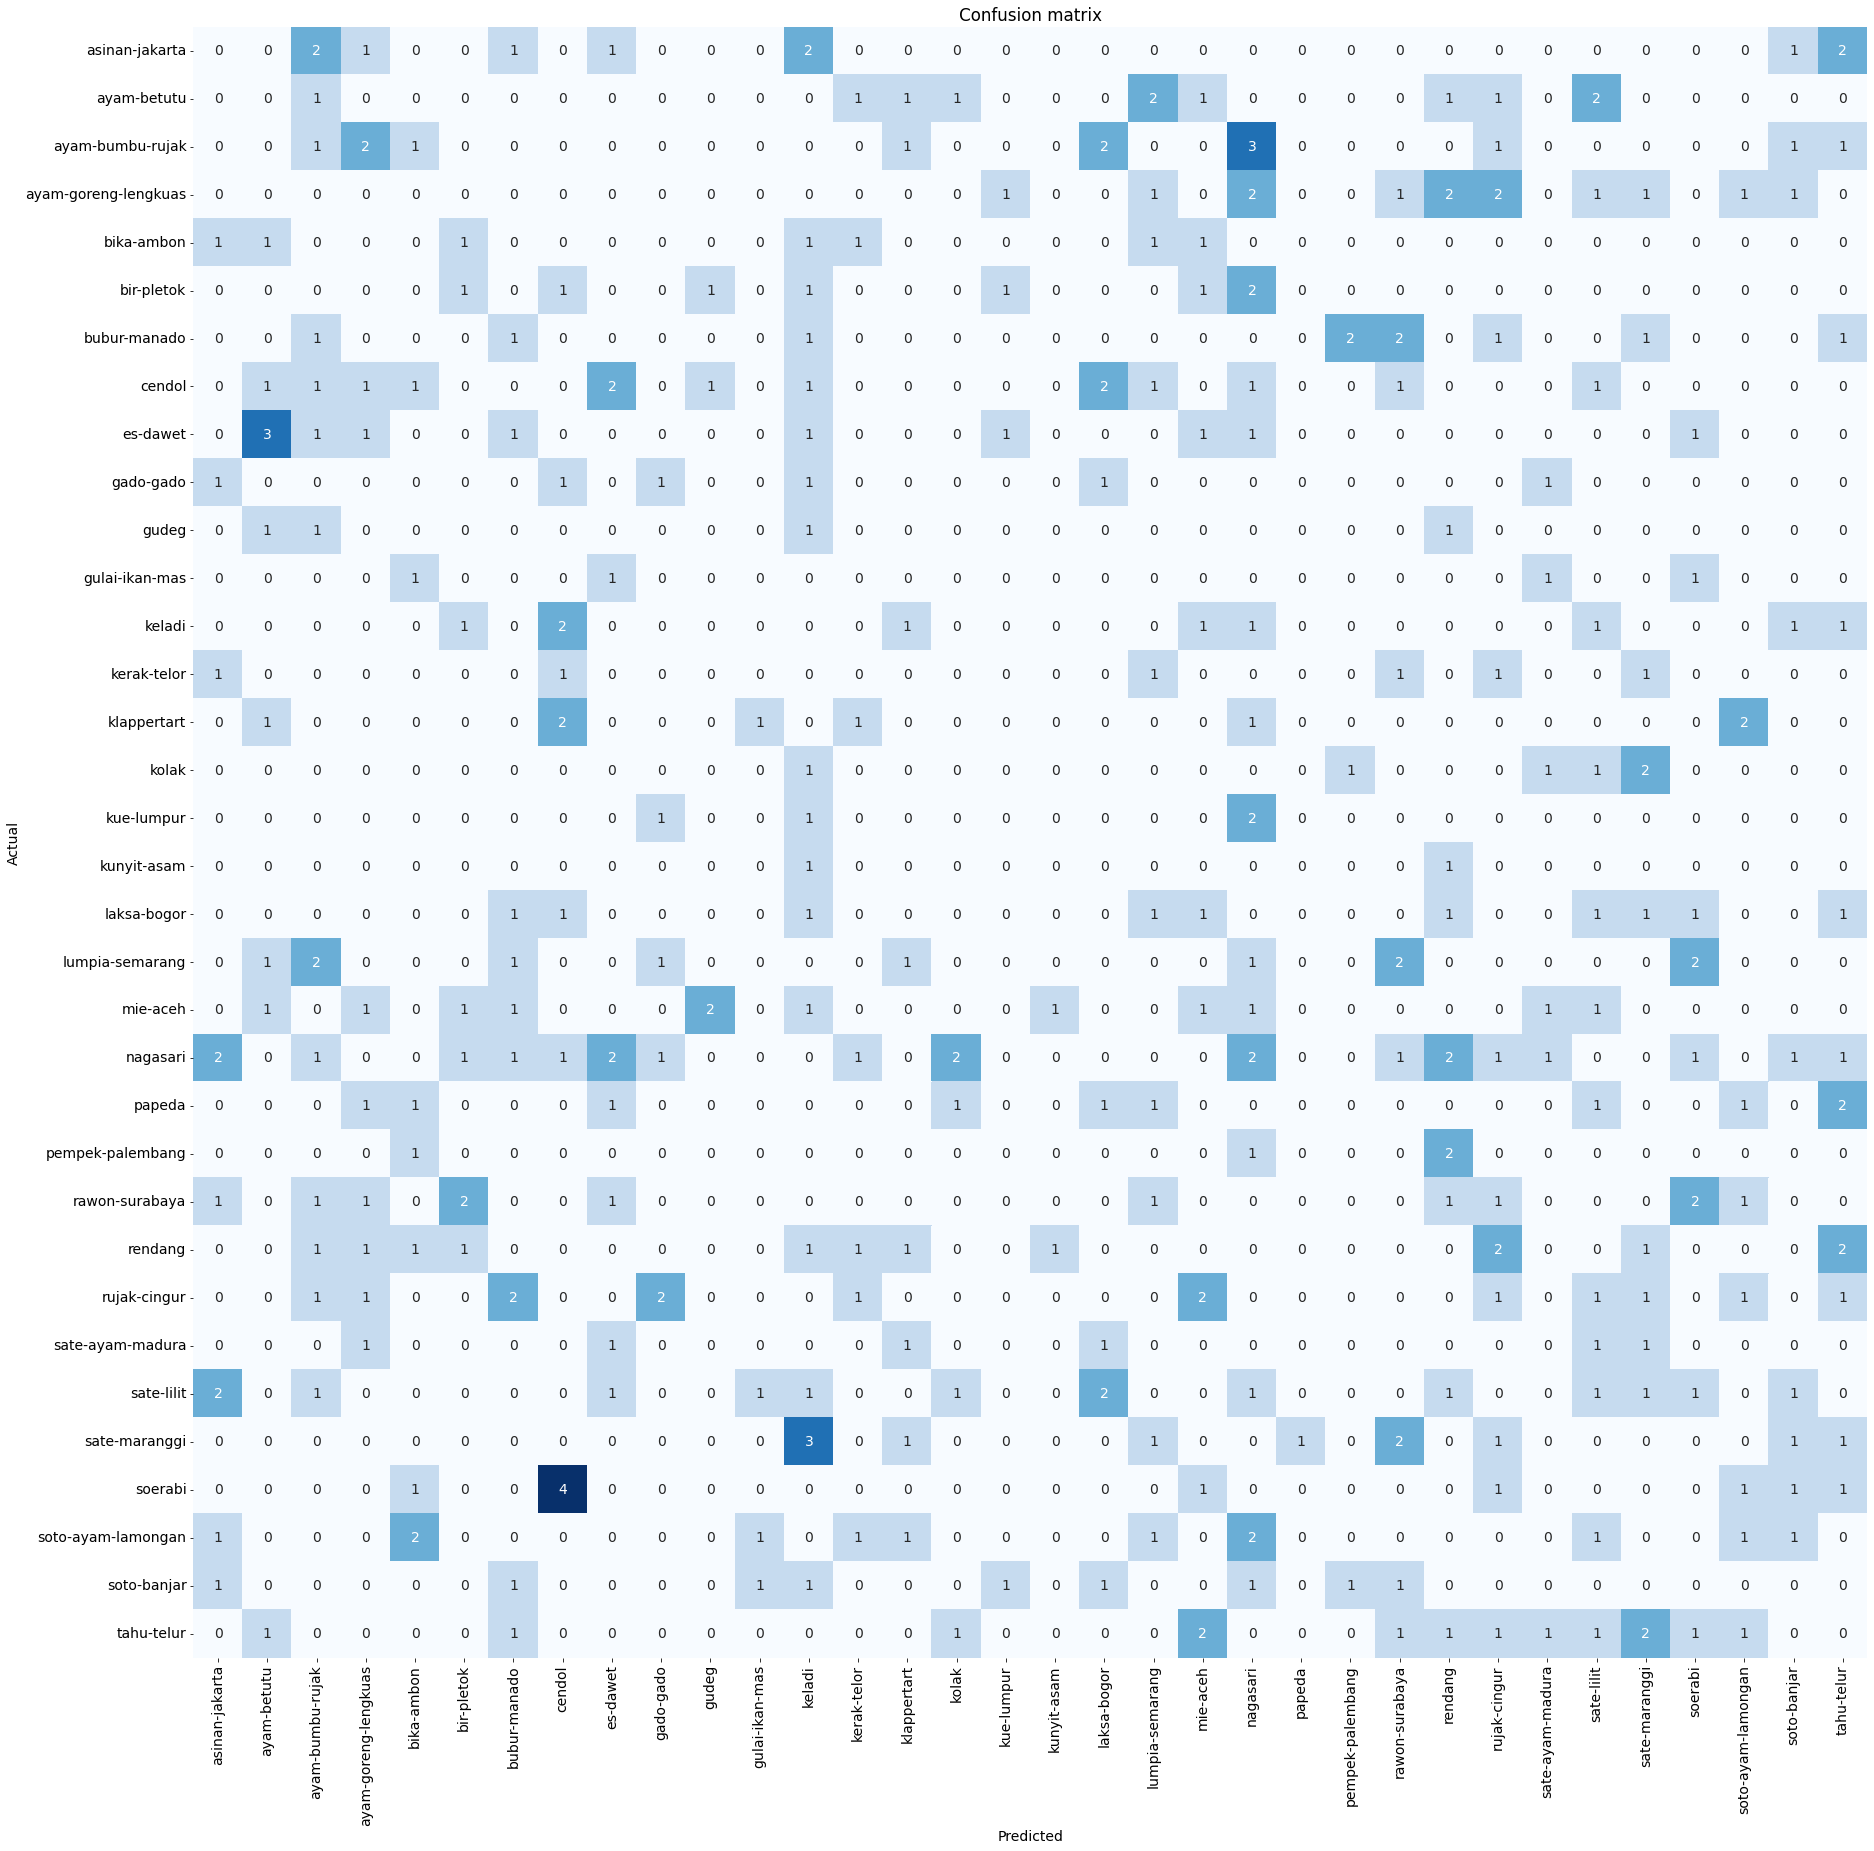

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(34) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(34) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [ ]:
print('Classification report:\n---------------------\n', clr)

Classification report:
---------------------
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        11
           2       0.07      0.08      0.07        13
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00         7
           5       0.12      0.12      0.12         8
           6       0.09      0.10      0.10        10
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        11
           9       0.17      0.17      0.17         6
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00         6
          16       0.00      0.00  

In [ ]:
model.save('/content/drive/MyDrive/Capstone Project - Foedtra/trained_model/model_v3')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone Project - Foedtra/trained_model/model_v3/assets


In [ ]:
model.save('/content/drive/MyDrive/Capstone Project - Foedtra/trained_model/foedtra_model3_improve.h5')